In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'come',
    'away',
    'spin'
]

data = np.concatenate([
    np.load('dataset/seq_come_1675815419.npy'),
    np.load('dataset/seq_away_1675815419.npy'),
    np.load('dataset/seq_spin_1675815419.npy'),
], axis=0)

data.shape

(542, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

x_data.shape, labels.shape

((542, 30, 99), (542,))

In [4]:
from keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))

y_data.shape

(542, 3)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2022)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(487, 30, 99) (487, 3)
(55, 30, 99) (55, 3)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
13/16 [=======================>......] - ETA: 0s - loss: 6.6885 - acc: 0.6875 
Epoch 1: val_acc improved from -inf to 0.58182, saving model to models\model.h5
16/16 [==============================] - 2s 28ms/step - loss: 6.5014 - acc: 0.6735 - val_loss: 6.6243 - val_acc: 0.5818 - lr: 0.0010
Epoch 2/200
15/16 [===========================>..] - ETA: 0s - loss: 6.5040 - acc: 0.6021
Epoch 2: val_acc improved from 0.58182 to 0.83636, saving model to models\model.h5
16/16 [==============================] - 0s 11ms/step - loss: 6.4512 - acc: 0.6037 - val_loss: 1.6981 - val_acc: 0.8364 - lr: 0.0010
Epoch 3/200
14/16 [=========================>....] - ETA: 0s - loss: 1.3353 - acc: 0.8415
Epoch 3: val_acc improved from 0.83636 to 0.96364, saving model to models\model.h5
16/16 [==============================] - 0s 12ms/step - loss: 1.2358 - acc: 0.8501 - val_loss: 1.3705 - val_acc: 0.9636 - lr: 0.0010
Epoch 4/200
14/16 [=========================>....] - ETA: 0s - loss: 0.3395 - acc: 0

In [23]:
import tensorflow as tf

run_model = tf.function(lambda x: model(x))

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(x_train.shape, model.inputs[0].dtype)
)

MODEL_DIR = "models/tflite"
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()


NameError: name 'TFLiteConverter' is not defined

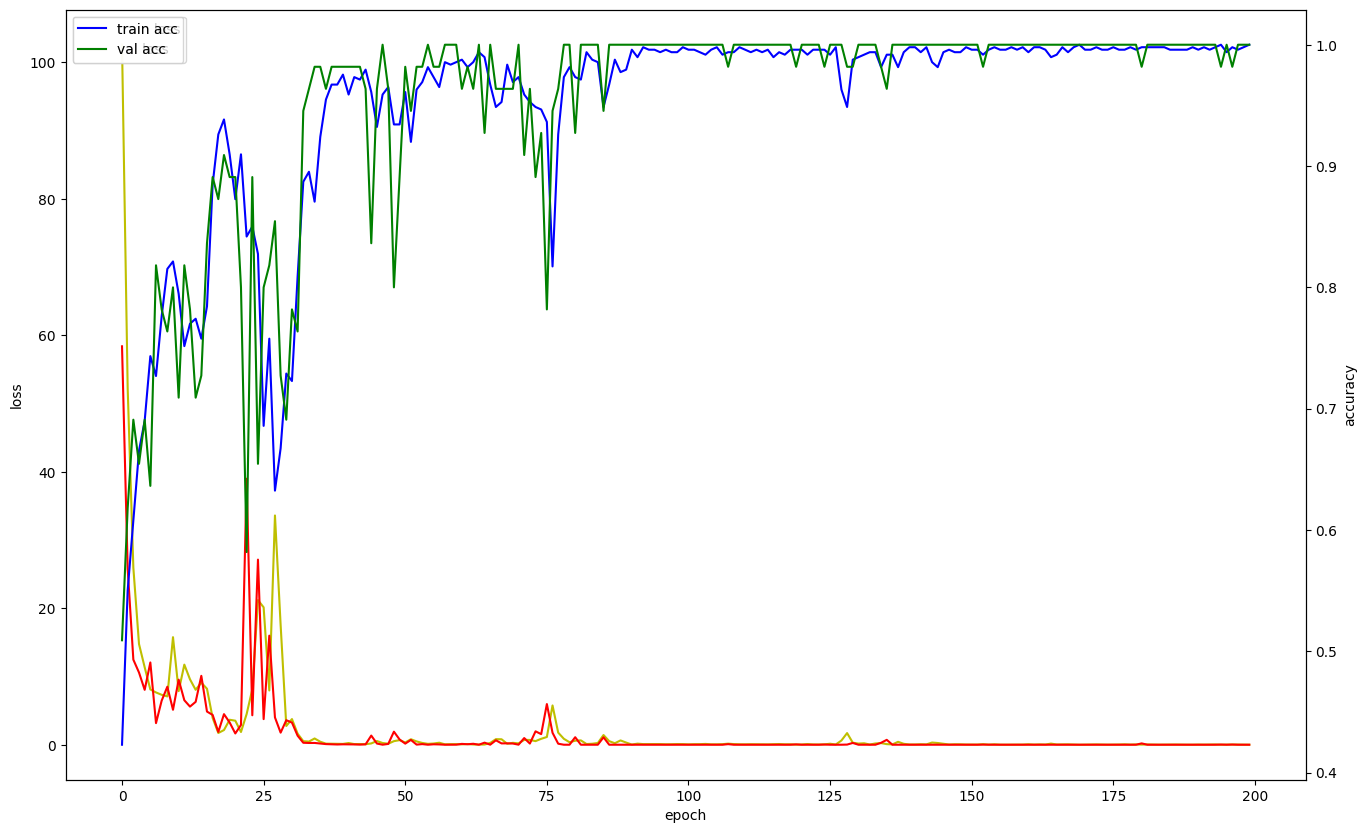

In [14]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [15]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

2/2 [==============================] - 0s 4ms/step


array([[[43,  0],
        [ 0, 12]],

       [[32,  0],
        [ 0, 23]],

       [[35,  0],
        [ 0, 20]]], dtype=int64)